In [1]:
import sys
sys.path.append('../..')

In [2]:
import h5py
import yaml
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import numpy as np

from utils import NavierStokesDataset
from net import UNet4Diffusion
from diff_fluids.baseline.unet.net import UNet
from diff_fluids.baseline.pinn.net import PINN
from denoising_diffusion import DenoisingDiffusion

In [3]:
train_ds = NavierStokesDataset(fileroot='../../data/', filename='ns_floating_sim_2d-seed1.h5', is_test=False)
test_ds = NavierStokesDataset(fileroot='../../data/', filename='ns_floating_sim_2d-seed1.h5', is_test=True)

The total number of samples is 32000
The number of batches is 800
The total number of samples is 8000
The number of batches is 200


In [4]:
with open('./config.yaml') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    eps_model = UNet4Diffusion(**configs['navier_stokes']['eps_model'])
    eps_model.load_state_dict(torch.load('./checkpoint/ns_incomp_N1000_T40.pth'))
    diffuser = DenoisingDiffusion(
        eps_model=eps_model,
        **configs['navier_stokes']['diffuser']
    ).cuda(1)

In [5]:
with open('../baseline/unet/config.yaml', 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    unet = UNet(**configs['model']).cuda(1)
    unet.load_state_dict(torch.load('../baseline/unet/checkpoint/ns_incomp_N1000_T40_UNet_baseline.pth'))
    unet = unet.cuda(1)

In [6]:
with open('../baseline/pinn/config.yaml', 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)
    pinn = PINN(**configs['model'])
    pinn.load_state_dict(torch.load('../baseline/pinn/checkpoint/ns_incomp_no800_T40_PINN_baseline.pth'))

In [10]:
sample = train_ds[0]
x = sample['x'].cuda(1)
y = sample['y'].cuda(1)

In [18]:
noisy_x = diffuser.sqrtab[30, None, None, None] * x + torch.randn_like(x) * diffuser.sqrtab[30, None, None, None]
t = torch.tensor([0.05], device='cuda:1')
eps_pred = diffuser.eps_model(noisy_x.unsqueeze(0), t, y.unsqueeze(0))

In [19]:
noisy_x = noisy_x.detach().cpu()
eps_pred = eps_pred.detach().cpu().squeeze()

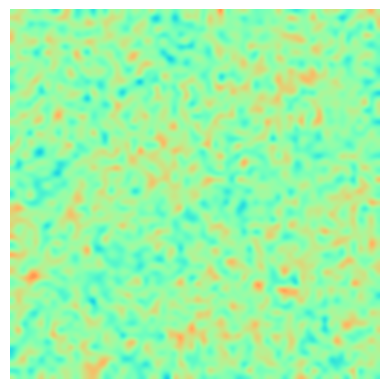

In [22]:
plt.imshow(noisy_x[0, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
plt.axis('off')
plt.savefig('../../assets/model_figure_use/noisy_velocity_u_sample.png', bbox_inches='tight', pad_inches=0, dpi=100)

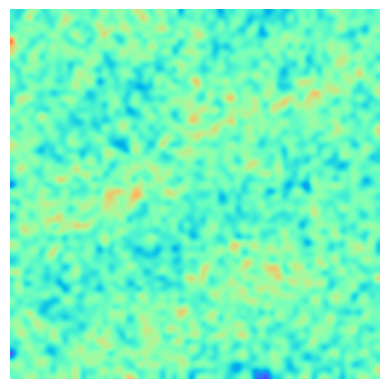

In [23]:
plt.imshow(noisy_x[1, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
plt.axis('off')
plt.savefig('../../assets/model_figure_use/noisy_velocity_v_sample.png', bbox_inches='tight', pad_inches=0, dpi=100)

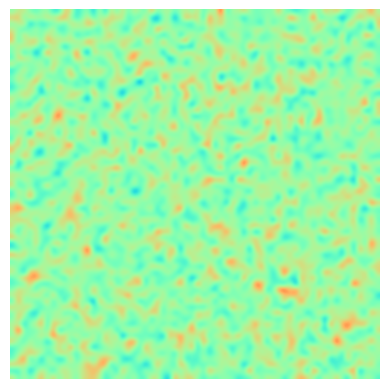

In [24]:
plt.imshow(eps_pred[0, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
plt.axis('off')
plt.savefig('../../assets/model_figure_use/eps_velocity_u_sample.png', bbox_inches='tight', pad_inches=0, dpi=100)

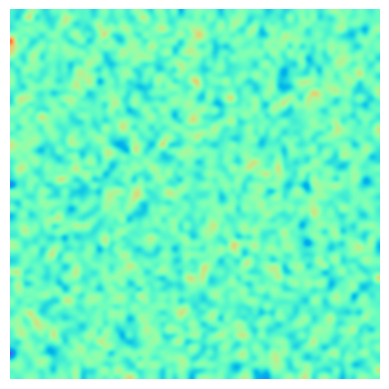

In [25]:
plt.imshow(eps_pred[1, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
plt.axis('off')
plt.savefig('../../assets/model_figure_use/eps_velocity_v_sample.png', bbox_inches='tight', pad_inches=0, dpi=100)

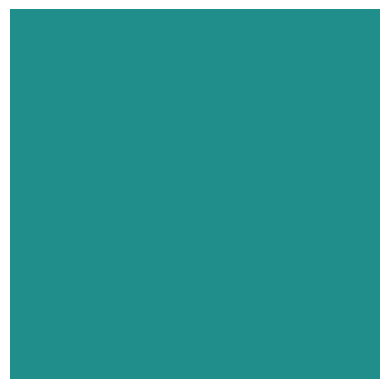

In [31]:
t = torch.tensor([0.05])
t = t[:, None].repeat(64, 64).detach()
plt.imshow(t, cmap='viridis', origin='lower', norm=colors.Normalize(vmin=0, vmax=0.1))
plt.axis('off')
plt.savefig('../../assets/model_figure_use/t_sample.png', bbox_inches='tight', pad_inches=0, dpi=100)

### Training set

In [32]:
test_times = [1.0, 5.0, 10.0, 20.0, 30.0 ,40.0]
time_idexs = [int(t-1) for t in test_times]
n_exp = 5
x0, y0 = [], []
for i in time_idexs:
    sample = train_ds[(n_exp-1)*40 + i]
    x0.append(sample['x'])
    y0.append(sample['y'])
x0 = torch.stack(x0)
y0 = torch.stack(y0)

In [34]:
x_train_pred_ddpm = diffuser.sample(torch.randn_like(x0).cuda(1), y0.cuda(1))
x_train_pred_ddpm = x_train_pred_ddpm.detach().cpu()
u_train_pred_ddpm, v_train_pred_ddpm = torch.chunk(x_train_pred_ddpm, 2, dim=1)
u_train_pred_ddpm = u_train_pred_ddpm.squeeze()
v_train_pred_ddpm = v_train_pred_ddpm.squeeze()

100%|██████████| 400/400 [00:18<00:00, 22.12it/s]


In [35]:
u0_train, v0_train = torch.chunk(x0, 2, dim=1)
u0_train = u0_train.squeeze()
v0_train = v0_train.squeeze()

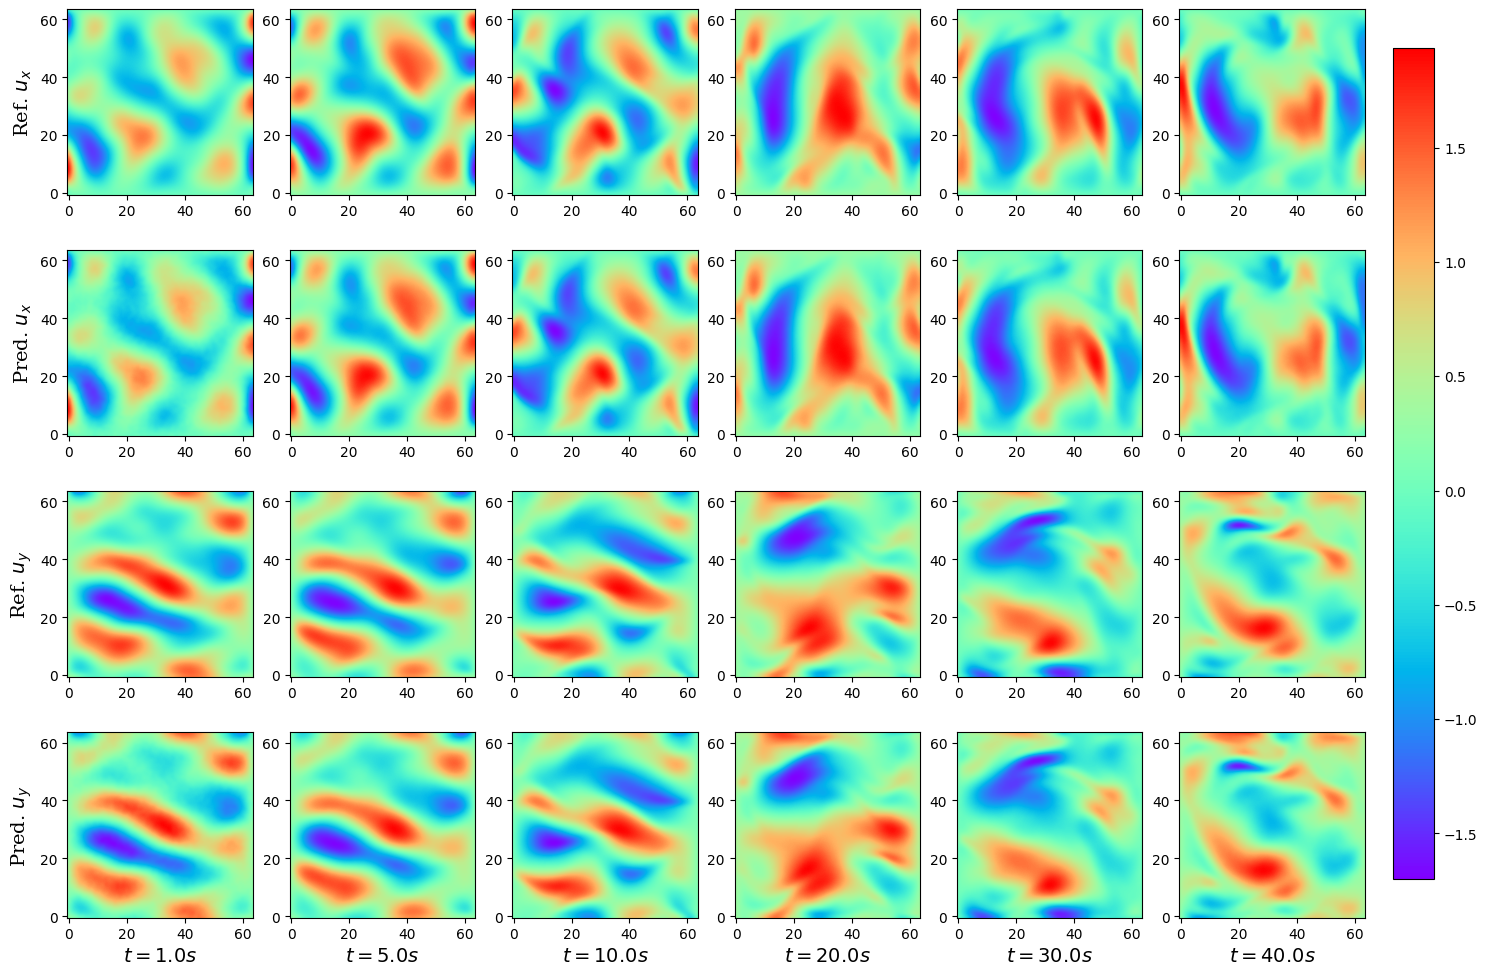

In [57]:
fig, ax = plt.subplots(4, 6, figsize=(18, 12))
for i in range(6):
    im = ax[0, i].imshow(u0_train[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[1, i].imshow(u_train_pred_ddpm[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[2, i].imshow(v0_train[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[3, i].imshow(v_train_pred_ddpm[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[3, i].set_xlabel(r"$t = {} s$".format(test_times[i]), fontsize=14, fontfamily='serif')
ax[0, 0].set_ylabel(r"Ref. $u_x$", fontsize=14, fontfamily='serif')
ax[1, 0].set_ylabel(r"Pred. $u_x$", fontsize=14, fontfamily='serif')
ax[2, 0].set_ylabel(r"Ref. $u_y$", fontsize=14, fontfamily='serif')
ax[3, 0].set_ylabel(r"Pred. $u_y$", fontsize=14, fontfamily='serif')
# add a thin colorbar for all the subplots on the left
fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.02, shrink=0.9)

In [58]:
fig.savefig('../../assets/ddpm_trainds_pred_vis.png', bbox_inches='tight', dpi=150)

In [75]:
u_train_abs_error_ddpm = torch.abs(u_train_pred_ddpm - u0_train)
v_train_abs_error_ddpm = torch.abs(v_train_pred_ddpm - v0_train)

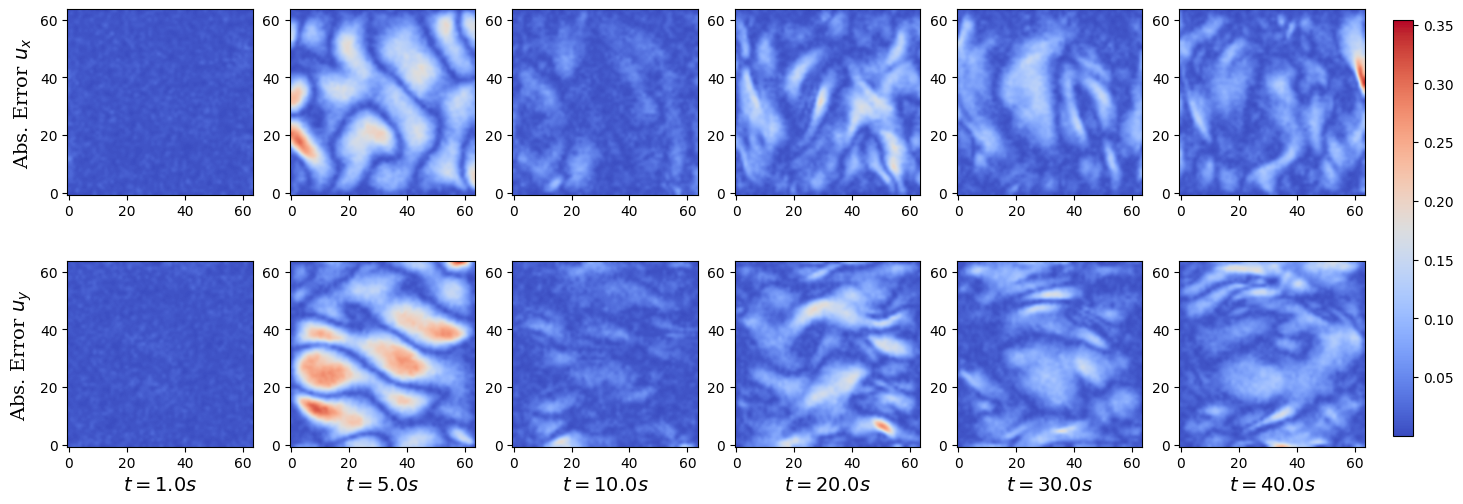

In [79]:
norm = colors.Normalize(
    vmin=min(u_train_abs_error_ddpm.min(), v_train_abs_error_ddpm.min()),
    vmax=max(u_train_abs_error_ddpm.max(), v_train_abs_error_ddpm.max())
)
fig, ax = plt.subplots(2, 6, figsize=(18, 6))
for i in range(6):
    im = ax[0, i].imshow(u_train_abs_error_ddpm[i, :, :], cmap='coolwarm', origin='lower', interpolation='bicubic', norm=norm)
    ax[1, i].imshow(v_train_abs_error_ddpm[i, :, :], cmap='coolwarm', origin='lower', interpolation='bicubic', norm=norm)
    ax[1, i].set_xlabel(r"$t = {} s$".format(test_times[i]), fontsize=14, fontfamily='serif')
ax[0, 0].set_ylabel(r"Abs. Error $u_x$", fontsize=14, fontfamily='serif')
ax[1, 0].set_ylabel(r"Abs. Error $u_y$", fontsize=14, fontfamily='serif')
# add a thin colorbar for all the subplots on the left
fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.02, shrink=0.9)

In [80]:
fig.savefig('../../assets/ddpm_trainds_abs_error_vis.png', bbox_inches='tight', dpi=150)

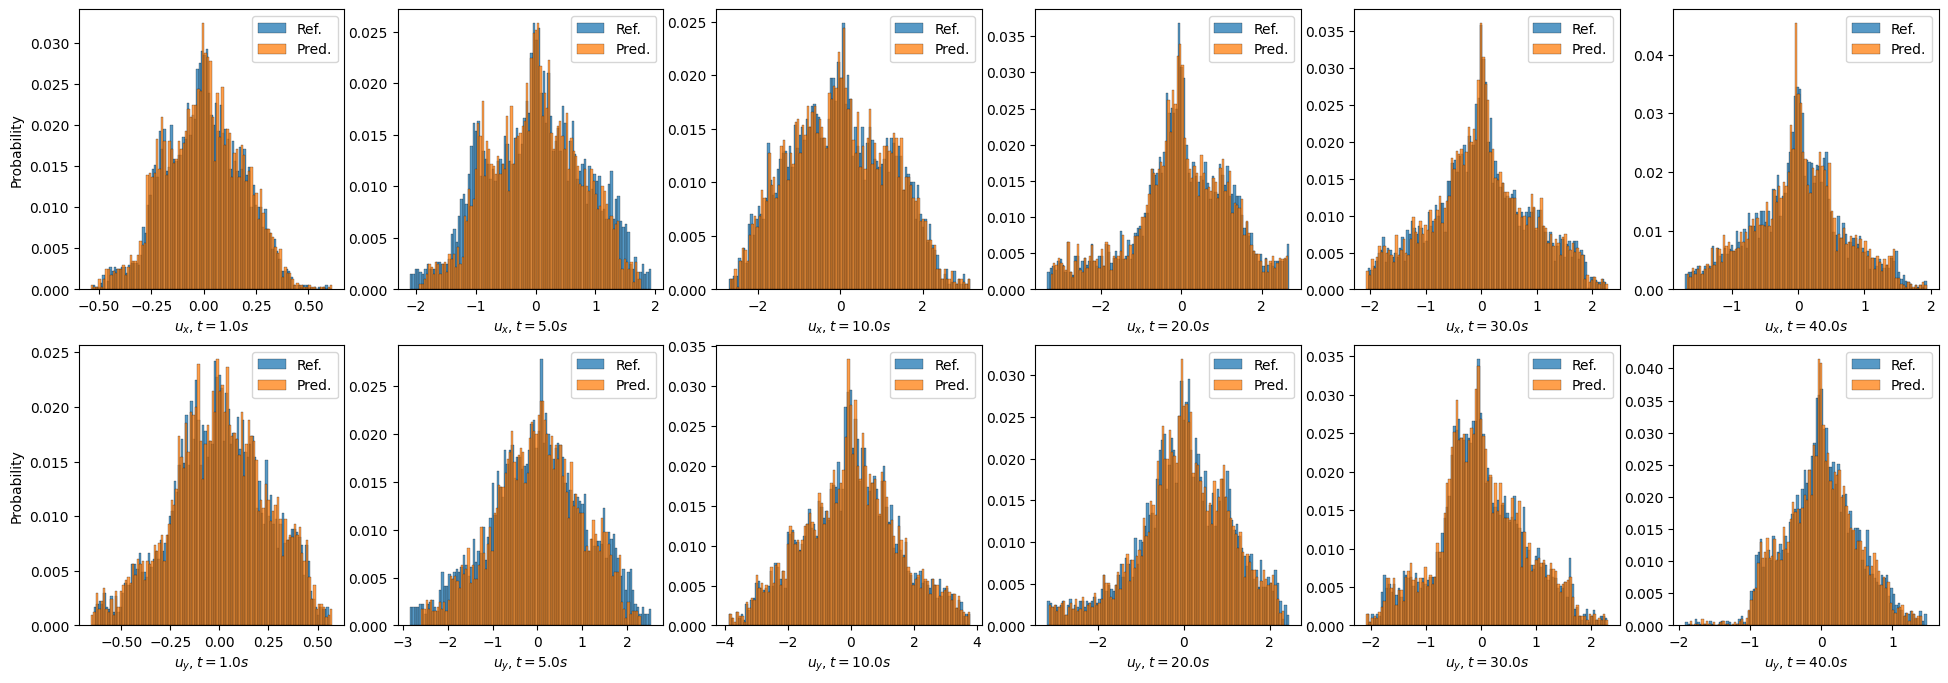

In [91]:
fig, ax = plt.subplots(2, 6, figsize=(24, 8))
for i in range(6):
    sns.histplot(u0_train[i].flatten(), ax=ax[0, i], bins=100, stat='probability', label='Ref.')
    sns.histplot(u_train_pred_ddpm[i].flatten(), ax=ax[0, i], bins=100, stat='probability', label='Pred.')
    ax[0, i].set_xlabel(fr'$u_x, t={test_times[i]}s$')
    ax[0, i].legend()
    sns.histplot(v0_train[i].flatten(), ax=ax[1, i], bins=100, stat='probability', label='Ref.')
    sns.histplot(v_train_pred_ddpm[i].flatten(), ax=ax[1, i], bins=100, stat='probability', label='Pred.')
    ax[1, i].set_xlabel(fr'$u_y, t={test_times[i]}s$')
    ax[1, i].legend()
    if i != 0:
        ax[0, i].set_ylabel('')
        ax[1, i].set_ylabel('')

In [92]:
fig.savefig('../../assets/ddpm_trainds_hist_vis.png', bbox_inches='tight', dpi=150)

### Test set

In [93]:
test_times = [1.0, 5.0, 10.0, 20.0, 30.0 ,40.0]
time_idexs = [int(t-1) for t in test_times]
n_exp = 1
x0, y0 = [], []
for i in time_idexs:
    sample = test_ds[(n_exp-1)*40 + i]
    x0.append(sample['x'])
    y0.append(sample['y'])
x0 = torch.stack(x0)
y0 = torch.stack(y0)

In [96]:
u0_test, v0_test = torch.chunk(x0, 2, dim=1)
u0_test = u0_test.squeeze()
v0_test = v0_test.squeeze()

In [94]:
x_test_pred_ddpm = diffuser.sample(torch.randn_like(x0).cuda(1), y0.cuda(1))
x_test_pred_ddpm = x_test_pred_ddpm.detach().cpu()
u_test_pred_ddpm, v_test_pred_ddpm = torch.chunk(x_test_pred_ddpm, 2, dim=1)
u_test_pred_ddpm = u_test_pred_ddpm.squeeze()
v_test_pred_ddpm = v_test_pred_ddpm.squeeze()

100%|██████████| 400/400 [00:18<00:00, 22.21it/s]


In [95]:
x_test_pred_unet = unet(y0.cuda(1))
x_test_pred_unet = x_test_pred_unet.detach().cpu()
u_test_pred_unet, v_test_pred_unet = torch.chunk(x_test_pred_unet, 2, dim=1)
u_test_pred_unet = u_test_pred_unet.squeeze()
v_test_pred_unet = v_test_pred_unet.squeeze()

In [97]:
x = torch.linspace(0, 64, 64)
y = torch.linspace(0, 64, 64)
x, y = torch.meshgrid(x, y, indexing='xy')
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
x = x.requires_grad_(True)
y = y.requires_grad_(True)

In [101]:
ones = torch.ones((64*64, 1))
u_test_pred_pinn = []
v_test_pred_pinn = []
for t in test_times:
    t_in = ones * t
    pred = pinn(x, y, t_in)
    psi = pred[:, 0]
    u_test_pred_pinn.append((torch.autograd.grad(psi.sum(), y, create_graph=True)[0]).detach().reshape(64, 64).permute(1, 0))
    v_test_pred_pinn.append((-torch.autograd.grad(psi.sum(), x, create_graph=True)[0]).detach().reshape(64, 64).permute(1, 0))
u_test_pred_pinn = torch.stack(u_test_pred_pinn)
v_test_pred_pinn = torch.stack(v_test_pred_pinn)

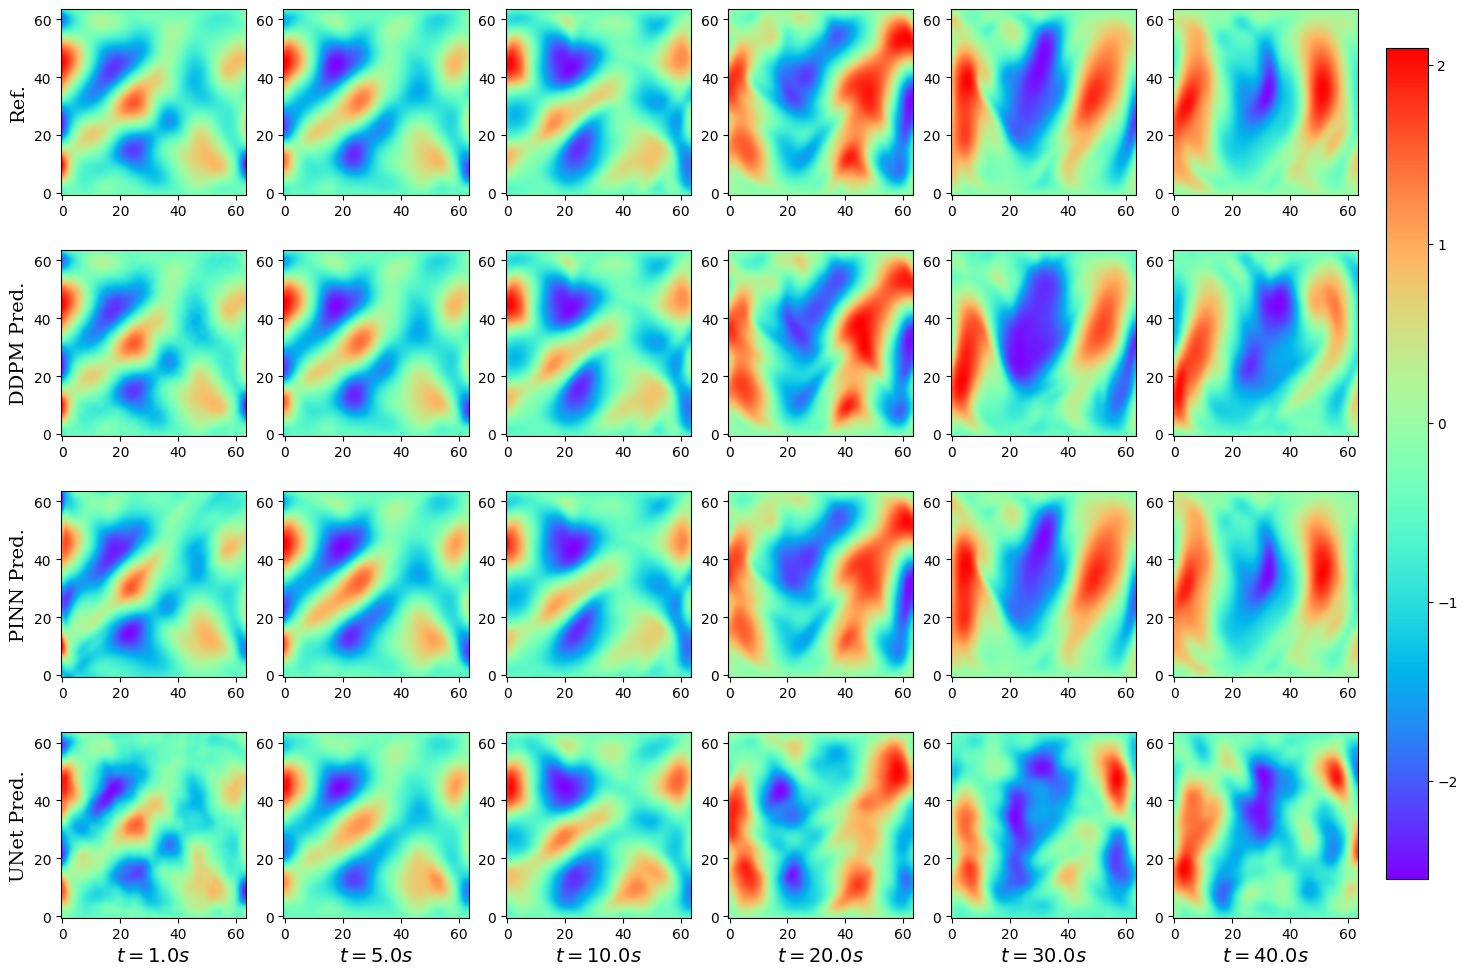

In [102]:
fig, ax = plt.subplots(4, 6, figsize=(18, 12))
for i in range(6):
    im = ax[0, i].imshow(u0_test[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[1, i].imshow(u_test_pred_ddpm[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[2, i].imshow(u_test_pred_pinn[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[3, i].imshow(u_test_pred_unet[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[3, i].set_xlabel(r"$t = {} s$".format(test_times[i]), fontsize=14, fontfamily='serif')
ax[0, 0].set_ylabel(r"Ref.", fontsize=14, fontfamily='serif')
ax[1, 0].set_ylabel(r"DDPM Pred.", fontsize=14, fontfamily='serif')
ax[2, 0].set_ylabel(r"PINN Pred.", fontsize=14, fontfamily='serif')
ax[3, 0].set_ylabel(r"UNet Pred.", fontsize=14, fontfamily='serif')
# add a thin colorbar for all the subplots on the left
fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.02, shrink=0.9)

In [103]:
fig.savefig('../../assets/testds_ux_models_vis.png', bbox_inches='tight', dpi=150)

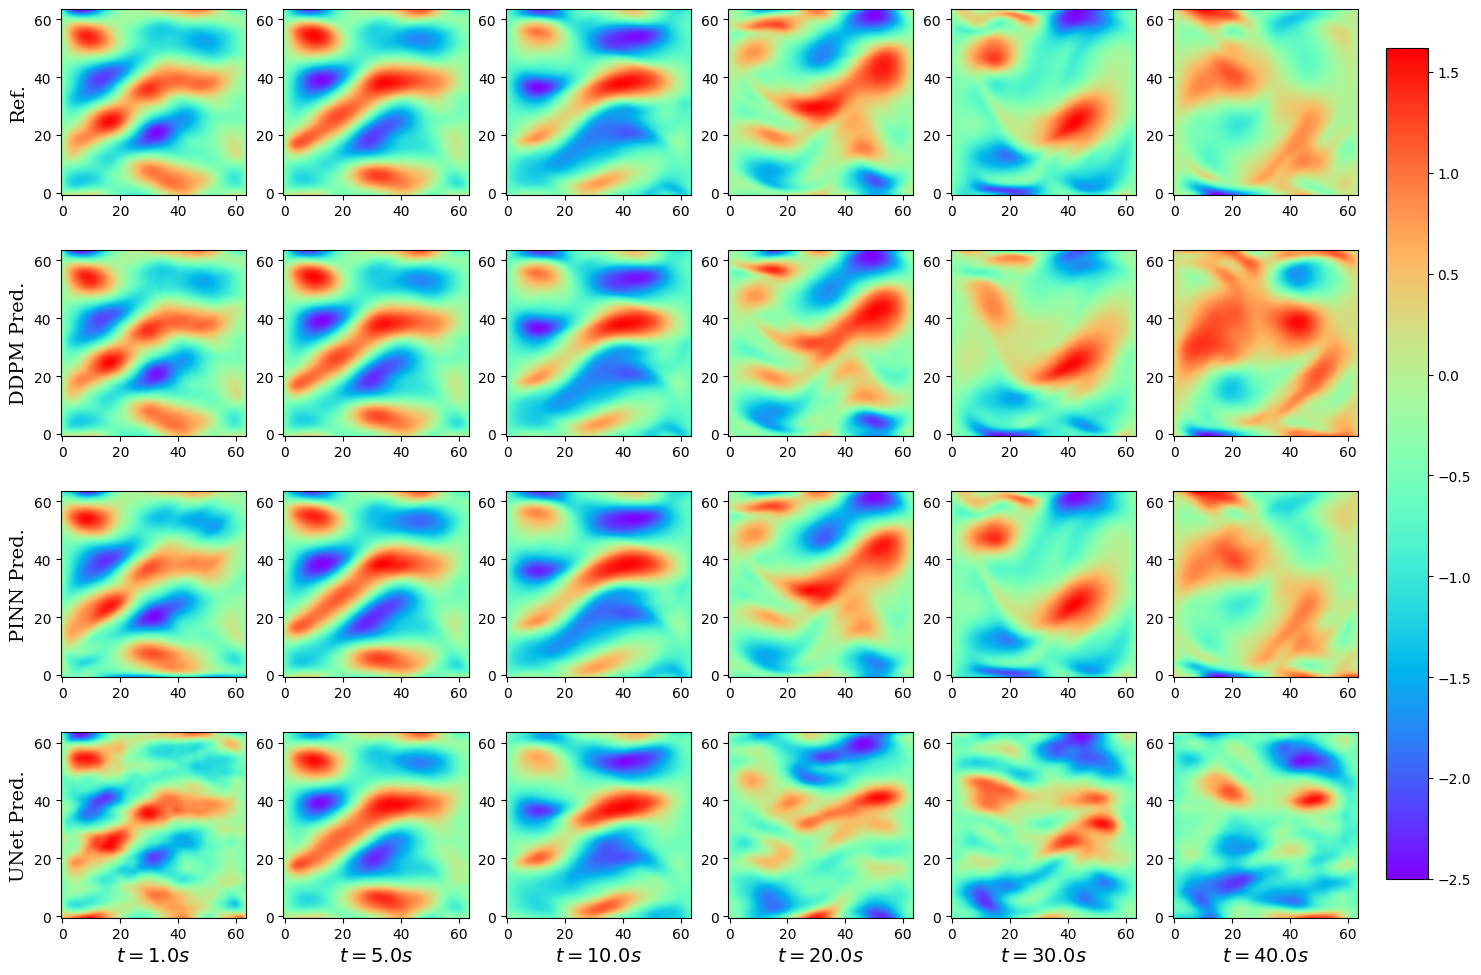

In [104]:
fig, ax = plt.subplots(4, 6, figsize=(18, 12))
for i in range(6):
    im = ax[0, i].imshow(v0_test[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[1, i].imshow(v_test_pred_ddpm[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[2, i].imshow(v_test_pred_pinn[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[3, i].imshow(v_test_pred_unet[i, :, :], cmap='rainbow', origin='lower', interpolation='bicubic')
    ax[3, i].set_xlabel(r"$t = {} s$".format(test_times[i]), fontsize=14, fontfamily='serif')
ax[0, 0].set_ylabel(r"Ref.", fontsize=14, fontfamily='serif')
ax[1, 0].set_ylabel(r"DDPM Pred.", fontsize=14, fontfamily='serif')
ax[2, 0].set_ylabel(r"PINN Pred.", fontsize=14, fontfamily='serif')
ax[3, 0].set_ylabel(r"UNet Pred.", fontsize=14, fontfamily='serif')
# add a thin colorbar for all the subplots on the left
fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.05, pad=0.02, shrink=0.9)

In [105]:
fig.savefig('../../assets/testds_vx_models_vis.png', bbox_inches='tight', dpi=150)

In [106]:
u_test_abs_error_ddpm = torch.abs(u_test_pred_ddpm - u0_test)
u_test_abs_error_pinn = torch.abs(u_test_pred_pinn - u0_test)
u_test_abs_error_unet = torch.abs(u_test_pred_unet - u0_test)
v_test_abs_error_ddpm = torch.abs(v_test_pred_ddpm - v0_test)
v_test_abs_error_pinn = torch.abs(v_test_pred_pinn - v0_test)
v_test_abs_error_unet = torch.abs(v_test_pred_unet - v0_test)

In [107]:
rmse_u_ddpm = torch.sqrt(torch.mean(u_test_abs_error_ddpm**2, dim=(1, 2)))
rmse_u_pinn = torch.sqrt(torch.mean(u_test_abs_error_pinn**2, dim=(1, 2)))
rmse_u_unet = torch.sqrt(torch.mean(u_test_abs_error_unet**2, dim=(1, 2)))
rmse_v_ddpm = torch.sqrt(torch.mean(v_test_abs_error_ddpm**2, dim=(1, 2)))
rmse_v_pinn = torch.sqrt(torch.mean(v_test_abs_error_pinn**2, dim=(1, 2)))
rmse_v_unet = torch.sqrt(torch.mean(v_test_abs_error_unet**2, dim=(1, 2)))

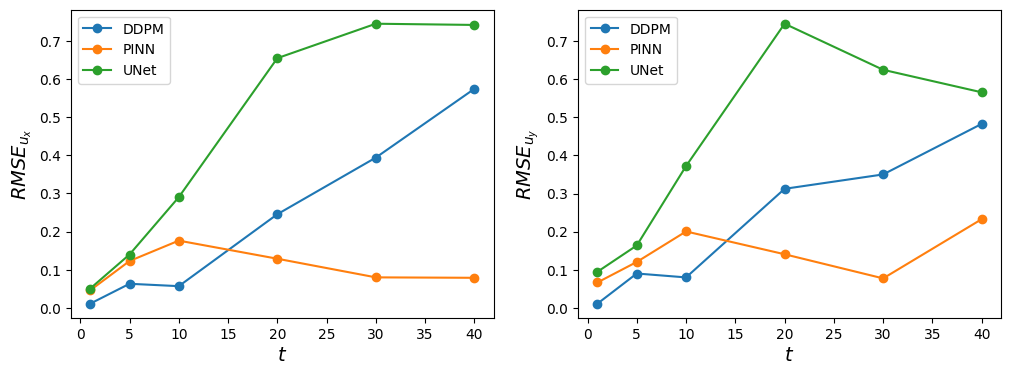

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(test_times, rmse_u_ddpm, label='DDPM', marker='o')
ax[0].plot(test_times, rmse_u_pinn, label='PINN', marker='o')
ax[0].plot(test_times, rmse_u_unet, label='UNet', marker='o')
ax[0].set_xlabel(r"$t$", fontsize=14, fontfamily='serif')
ax[0].set_ylabel(r"$RMSE_{u_x}$", fontsize=14, fontfamily='serif')
ax[0].legend()
ax[1].plot(test_times, rmse_v_ddpm, label='DDPM', marker='o')
ax[1].plot(test_times, rmse_v_pinn, label='PINN', marker='o')
ax[1].plot(test_times, rmse_v_unet, label='UNet', marker='o')
ax[1].set_xlabel(r"$t$", fontsize=14, fontfamily='serif')
ax[1].set_ylabel(r"$RMSE_{u_y}$", fontsize=14, fontfamily='serif')
ax[1].legend()

In [111]:
fig.savefig('../../assets/testds_rmse_models.png', bbox_inches='tight', dpi=150)